# **MobileNet + BiLSTM Inference**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip '/content/drive/MyDrive/DL_Project_Data_Source/UCF50.zip'

In [ ]:
# importing the libraries
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.xception import Xception, preprocess_input 
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input 
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from tabulate import tabulate
from tensorflow import keras
import tensorflow as tf
import pandas as pd
import numpy as np
import pickle
import cv2
import os

tf.get_logger().setLevel('INFO')

In [27]:
def load_files():
  with open('/content/drive/MyDrive/DL_Project/test/test_data.pkl', 'rb') as file:
      test_data = pickle.load(file)

  with open('/content/drive/MyDrive/DL_Project/test/test_labels.pkl', 'rb') as file:
      test_labels = pickle.load(file)

  return (test_data, test_labels)

In [11]:
# Define hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 32

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 1280

In [ ]:
IMG_SIZE = 224

def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
        
    return np.array(frames)

In [9]:
def build_feature_extractor():
    feature_extractor = MobileNetV2(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")

feature_extractor = build_feature_extractor()

9406464/9406464 [==============================] - 0s 0us/step


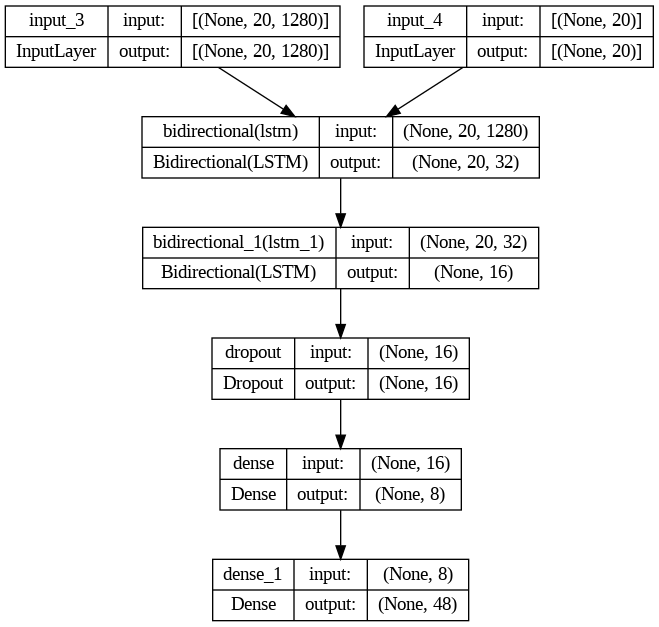

In [14]:
model = keras.models.load_model('/content/MobileNet_plus_BiLSTM.h5')
plot_model(model, to_file='mobilenet.png', show_shapes=True, show_layer_names=True)

In [ ]:
def prepare_single_video(frames, feature_extractor):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :], verbose=0)
        frame_mask[i, :length] = 1

    return frame_features, frame_mask

def sequence_prediction(path, label_processor, sequence_model, feature_extractor):
    class_vocab = label_processor.get_vocabulary()
    
    output = [['Class', 'Percentage of Belonging (in %)']]
    frames = load_video('/content/' + os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames, feature_extractor)
    probabilities = sequence_model.predict([frame_features, frame_mask], verbose=0)[0]

    print("Probabilities of Each Class: \n")
    for i in np.argsort(probabilities)[::-1]:
        output.append([class_vocab[i], probabilities[i] * 100])

    print(tabulate(output, headers='firstrow', tablefmt='github'))
    return frames

In [29]:
if __name__ == '__main__':
  train_csv = pd.read_csv('/content/drive/MyDrive/DL_Project_Data/train.csv')
  testset = pd.read_csv('/content/drive/MyDrive/DL_Project_Data/test.csv')

  label_processor = keras.layers.StringLookup(num_oov_indices=0, vocabulary = np.unique(train_csv["tag"]))

  test_data, test_labels = load_files()
  test_video = np.random.choice(testset["video_name"].values.tolist())
  print(f"Test video path: {test_video}\n")
  test_frames = sequence_prediction(test_video, label_processor, model, feature_extractor)

Test video path: /content/UCF50/RockClimbingIndoor/v_RockClimbingIndoor_g07_c01.avi

Probabilities of Each Class: 

| Class              |   Percentage of Belonging (in %) |
|--------------------|----------------------------------|
| RockClimbingIndoor |                     61.0559      |
| PushUps            |                     21.448       |
| PlayingViolin      |                      9.58698     |
| VolleyballSpiking  |                      1.69492     |
| Swing              |                      1.53459     |
| Mixing             |                      1.46452     |
| RopeClimbing       |                      0.701645    |
| CleanAndJerk       |                      0.585641    |
| PlayingTabla       |                      0.437737    |
| PlayingGuitar      |                      0.422963    |
| SoccerJuggling     |                      0.323669    |
| TrampolineJumping  |                      0.201805    |
| Diving             |                      0.1224      |
| WalkingWithD

In [30]:
model.evaluate([test_data[0], test_data[1]], test_labels)

5/5 [==============================] - 0s 9ms/step - loss: 2.3267 - accuracy: 0.4511


[2.3267295360565186, 0.451127827167511]